### Density Maps for light curves

In [1]:
import pandas as pd
import numpy as np
import zarr
from utils import *
pd.set_option('display.max_columns', 999)

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Run this cell if on SciServer
init()

#### Define Function to Make Density Maps

In [7]:
def dmdt(x, y):
    '''Return dm dt pairs, with dt in the log10 space
    
    Args:
        x(array): An array of time points.
        y(array): The magnitude at each time point in x.
    
    Returns:
        log_dts(array): An array of delta_t between any pair of observations, in
            the log10 scale.
        dms(array): An array of delta_mag corresponding to each delta_t in log_dts.
        dt_amp(float): The largest value in log_dts.
        dm_amp(float): The larges absolute value in dms. 
    '''
    allDiffs = [] # time diff
    allMagDiffs = [] # mag diff
    times = x
    mags = y

    for i in np.arange(1,times.size,1):
        allMagDiffs.append((mags - np.roll(mags, i))[i:])
        allDiffs.append((times-np.roll(times,i))[i:])
        log_dts = np.log10(np.concatenate(allDiffs))
        dms = np.concatenate(allMagDiffs)
    
    dm_amp = np.abs(dms).max() # largest change in mag
    dt_amp = log_dts.max() # largest time interveral
    
    return log_dts, dms, dt_amp, dm_amp


def plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.1, y_bin_size=0.05):
    '''Plot the colored DmDt density plot without columne-wise normalization.
    
    Args:
        x(array): An array of time points.
        y(array): The magnitude at each time point in x.
        x_bin_size(float): The size of dt bins, in the log scale.
        y_bin_size(float): The size of dm bins.        
    '''
    
    x_bins = np.int(dt_amp/x_bin_size) # compute number of x bins
    y_bins = np.int(dm_amp/y_bin_size) # compute number of x bins

    # plot
    fig = plt.figure(figsize=(8,6))
    _ = plt.hist2d(log_dts, dms, range=[[0, dt_amp], [-dm_amp, dm_amp]], bins=(x_bins, y_bins))
    plt.colorbar()
    
    return _
    
def plotNormDmDt(denVal, filename=None):
    '''Plot the grayscale DmDt density plot with columne-wise normalization.
    
    Args:
        denVal(array): Density values computed from a colored density map.
        
    '''
    
    fig, ax = plt.subplots(1,1, figsize=(6,6)) # init figure
    
    # perform normalization
    denVal = np.rot90(denVal[0]) # rotate to make x be dt
    y_dim = denVal.shape[0] # number of rows
    x_dim = denVal.shape[1] # number of columns

    # sum over all columns and assign 0 to be 1
    normTotal = np.sum(denVal, axis=0)
    normTotal[normTotal == 0] = 1

    # divide each bin values by normalization and reshape
    normMask = np.repeat(normTotal, y_dim).reshape((x_dim, y_dim)).T
    normd = np.divide(denVal, normMask)

    plt.imshow(np.log(normd), cmap=plt.cm.Greys, extent=[0,3, -1.5, 1.5])
    ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length=5)
    plt.xlabel('$log_{10}(\Delta t\,[days])$', fontsize=15)
    plt.ylabel('$\Delta m \,(arb. unit)$', fontsize=15)
    
    if filename is not None:
        plt.savefig(filename)

### 1. QSO Density Maps
#### 1.1. Single band 

In [4]:
lc = get_sdss_lc(5)
lc = lc.dropna(subset=['dered_g'])

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


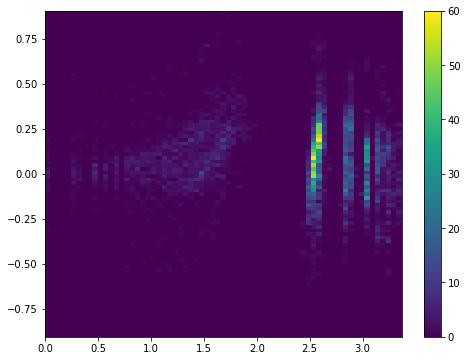

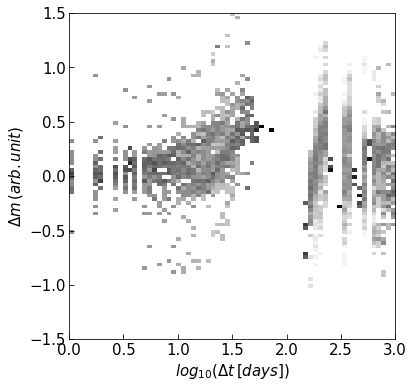

In [8]:
# cacluate dm dt
log_dts, dms, dt_amp, dm_amp = dmdt(lc.mjd_g.values, lc.dered_g.values)

# denVal is important for making normalized plot
denVal = plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.05, y_bin_size=0.01) 
plotNormDmDt(denVal, '../temp/quasar_g.pdf')

#### 1.2 Non-parametric LC merging?

In [9]:
lc = lc.dropna(subset=['dered_g', 'dered_u', 'dered_r', 'dered_i', 'dered_z']) # remove nan

In [10]:
# cacluate dm dt for each band
g_log_dts, g_dms, g_dt_amp, g_dm_amp = dmdt(lc.mjd_g.values, lc.dered_g.values)
r_log_dts, r_dms, r_dt_amp, r_dm_amp = dmdt(lc.mjd_r.values, lc.dered_r.values)
i_log_dts, i_dms, i_dt_amp, i_dm_amp = dmdt(lc.mjd_i.values, lc.dered_i.values)

# combine dm dt from g, r, i bands
log_dts = np.append([g_log_dts, r_log_dts], i_log_dts)
dms = np.append([g_dms, r_dms], i_dms)

# take the median of three amplitudes to make plots
## catastrophic error could occur if one of the bands has spurious brighness change
dt_amp = np.median([g_dt_amp, r_dt_amp, i_dt_amp])
dm_amp = np.median([g_dm_amp, r_dm_amp, i_dt_amp])

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


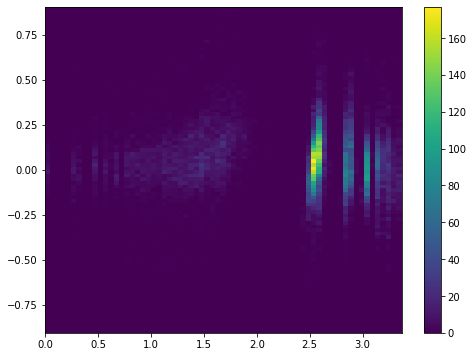

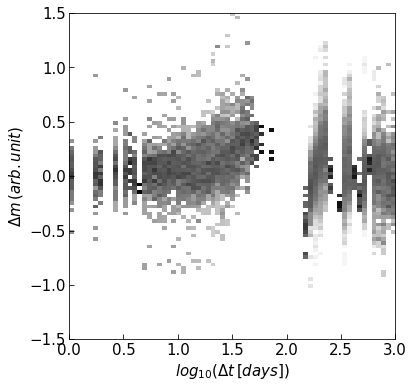

In [12]:
# make colored and grayscale normalized density plots
denVal = plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.05, y_bin_size=0.01)
plotNormDmDt(denVal, '../temp/quasar_gri.pdf')

### 1. Variable Stars Density Maps
#### 1.1. Single band 

In [13]:
varlc = get_sdss_lc(100012)
varlc = varlc.dropna(subset=['dered_g'])

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


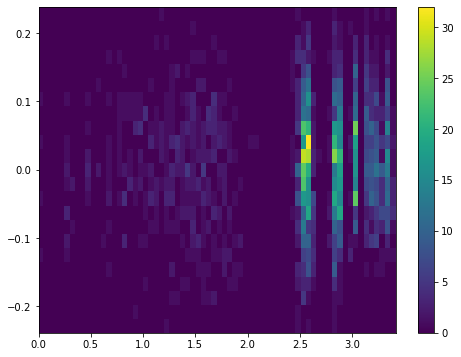

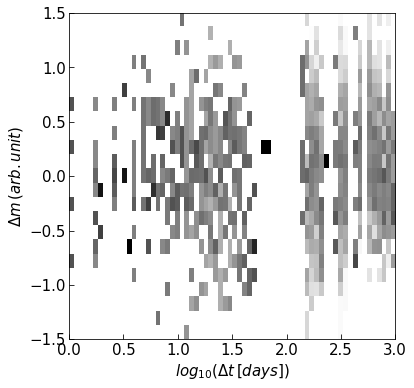

In [14]:
log_dts, dms, dt_amp, dm_amp = dmdt(varlc.mjd_g.values, varlc.dered_g.values)
denVal = plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.05, y_bin_size=0.01)
plotNormDmDt(denVal, '../temp/star_g.pdf')

#### 1.2 Non-parametric LC merging?

In [15]:
varlc = varlc.dropna(subset=['dered_g', 'dered_u', 'dered_r', 'dered_i', 'dered_z']) # remove nan

In [16]:
g_log_dts, g_dms, g_dt_amp, g_dm_amp = dmdt(varlc.mjd_g.values, varlc.dered_g.values)
r_log_dts, r_dms, r_dt_amp, r_dm_amp = dmdt(varlc.mjd_r.values, varlc.dered_r.values)
i_log_dts, i_dms, i_dt_amp, i_dm_amp = dmdt(varlc.mjd_i.values, varlc.dered_i.values)

In [17]:
log_dts = np.append([g_log_dts, r_log_dts], i_log_dts)
dms = np.append([g_dms, r_dms], i_dms)

## catastrophic error could occur if one of the bands has spurious brighness change
dt_amp = np.median([g_dt_amp, r_dt_amp, i_dt_amp])
dm_amp = np.median([g_dm_amp, r_dm_amp, i_dt_amp])

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


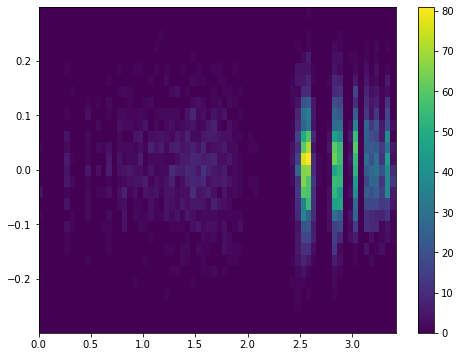

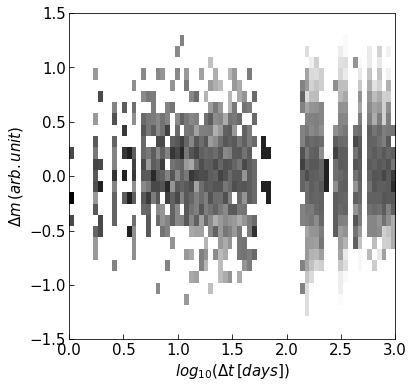

In [18]:
denVal = plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.05, y_bin_size=0.01)
plotNormDmDt(denVal, '../temp/star_gri.pdf')